In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os

from skluc.main.utils import logger

matplotlib.rcParams.update({'font.size': 14})
pd.set_option('display.expand_frame_repr', False)

2019-01-14 10:01:00,435 [2287] DEBUG    matplotlib.backends: backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
def build_df(dirname, filename):
    filepath = os.path.join(dirname, filename)
    df = pd.read_csv(filepath)
    df = df.apply(pd.to_numeric, errors="ignore")
    df = df.drop_duplicates()
    col_to_delete = ['--chi-square-PD-kernel', '--chi-square-kernel',
       '--cifar10', '--cifar100', '--exp-chi-square-kernel',
       '--intercept-constant', '--laplacian-kernel', '--linear-kernel',
       '--mnist', '--quiet', '--rbf-kernel',
       '--sigmoid-kernel',  '--svhn',
       '--tensorboard', '--validation-size'
       , 'deepstrom','dense', 
                     "--non-linear", "--non-linearity", "--num-epoch",
                     "--train-size", "--second-layer-size", "activation_function",
                     "deepstrom_activation", "--real-nystrom"
            ]
    for c in col_to_delete:
        df = df.drop([c], axis=1)
    return df


In [3]:
DIRNAME = "/home/luc/PycharmProjects/deepstrom_network/results/2019-01/classif_end_to_end_mnist_manual/"
FILENAME = "gathered_results.csv"
df_deepstrom_grid = build_df(DIRNAME, FILENAME)

In [37]:
DIRNAME = "/home/luc/PycharmProjects/deepstrom_network/results/2019-01/classif_end_to_end_deepstrom_mnist_svhn/"
FILENAME = "gathered_results.csv"
df_deepstrom = build_df(DIRNAME, FILENAME)
df_deepstrom = df_deepstrom[df_deepstrom["dataset"] == "mnist"]

In [38]:
DIRNAME = "/home/luc/PycharmProjects/deepstrom_network/results/2019-01/classif_end_to_end_dense_mnist_svhn/"
FILENAME = "gathered_results.csv"
df_dense = build_df(DIRNAME, FILENAME)
df_dense = df_dense[df_dense["dataset"] == "mnist"]

In [39]:
def get_sorted_acc_for_dataset(df_, name):
    df_dataset = df_[df_["dataset"] == name]
    df_dataset = df_dataset.sort_values(by="val_acc", ascending=False)
    return df_dataset

In [40]:
nb_classes_datasets = {
    "svhn": 10,
    "cifar10": 10,
    "mnist": 10,
    "cifar100": 100
}

nb_feature_convs = {
    "svhn": 512,
    "cifar10": 512,
    "mnist": 16,
    "cifar100": 512
}

min_acc = 0.7
max_acc = 1.1
DATANAME = "mnist"

In [41]:
def post_processing_figures(f, ax, nbparamdeepstrom, subsample_sizes):
    ax.set_ylim(min_acc, max_acc)
    ax.set_ylabel("Accuracy")
    ax.set_xticks([1e4, 1e5, 1e6])
    ax.set_xlabel("# Learnable Parameters")
    ax.legend(bbox_to_anchor=(0.5, -0.20), loc="upper center", ncol=2)
    ax.set_xticklabels([1e4, 1e5, 1e6])
    ax.set_xscale("symlog")

    ax_twin = ax.twiny()
    ax_twin.set_xscale("symlog")
    ax_twin.set_xlim(ax.get_xlim())
    ax_twin.set_xticks(sorted(nbparamdeepstrom))
    ax_twin.set_xticklabels(sorted(subsample_sizes))
    ax_twin.set_xlabel("Subsample Size")
    ax.set_title("{}".format(DATANAME), y=1.2)

    f.set_size_inches(8, 6)
    f.tight_layout()
    f.subplots_adjust(bottom=0.3)

    out_name = "end_to_end_{}".format(DATANAME)
    return
    base_out_dir = os.path.abspath(__file__.split(".")[0])
    base_out_dir_path = pathlib.Path(base_out_dir) / "images"
    base_out_dir_path.mkdir(parents=True, exist_ok=True)
    out_path = obase_out_dir_path / out_name
    logger.debug(out_path)
    f.savefig(out_path)

In [42]:
def create_figure_from_df_deepstrom(df_deeps, df_dense, name_fig):
    kernel_names = set(df_deeps["kernel"].values)
    nys_size = set(df_deeps["--nys-size"].values)
    gamma_values = set(df_deeps["--gamma"].values)
    gamma_values.remove("None")

    logger.debug("Nystrom possible sizes are: {}".format(nys_size))
    logger.debug("Kernel functions are: {}".format(kernel_names))
    display(df_deeps)
    df_data = df_deeps
    nb_classes_dataset = nb_classes_datasets[DATANAME]
    nb_feature_conv = nb_feature_convs[DATANAME]
    f, ax = plt.subplots()
    for k_name in kernel_names:
        df_kernel = df_data[df_data["kernel"] == k_name]
        if k_name == "rbf":
            for g_val in gamma_values:
                k_name = "rbf" + "_" + str(g_val)
                df_rbf = df_kernel[df_kernel["--gamma"] == g_val]
                accuracies_kernel = df_rbf["test_acc"]
                subsample_sizes_kernel = df_rbf["--nys-size"].astype(int)
                np_param = (np.square(subsample_sizes_kernel) +  # m x m
                            subsample_sizes_kernel * nb_classes_dataset)  # m x c
                sorted_idx = np.argsort(np_param.values)
                xx = np_param.values[sorted_idx]
                print(accuracies_kernel.values[sorted_idx])
                yy = accuracies_kernel.values[sorted_idx].astype(float)
                ax.plot(xx, yy, marker="x", label=f"Deepstrom {k_name}")
        else:
            accuracies_kernel = df_kernel["test_acc"]
            subsample_sizes_kernel = df_kernel["--nys-size"].astype(int)
            np_param = (np.square(subsample_sizes_kernel) +  # m x m
                        subsample_sizes_kernel * nb_classes_dataset)  # m x c
            sorted_idx = np.argsort(np_param.values)
            xx = np_param.values[sorted_idx]
            print(accuracies_kernel.values[sorted_idx])
            yy = accuracies_kernel.values[sorted_idx].astype(float)
            ax.plot(xx, yy, marker="x", label=f"Deepstrom {k_name}")

    df_dense["--out-dim"] = df_dense["--out-dim"].astype(np.int)
    df_dense = df_dense.sort_values(by=["--out-dim"])
    accuracies_dense_mean = np.mean(
        np.array([list(df_dense[df_dense["--seed"] == seed_v]["test_acc"]) for seed_v in
                  range(5)]), axis=0)
    accuracies_dense_std = np.std(
        np.array([list(df_dense[df_dense["--seed"] == seed_v]["test_acc"]) for seed_v in
                  range(5)]), axis=0)
    
    out_dim_dense = np.array(sorted([int(n) for n in np.unique(df_dense["--out-dim"])]))
    np_param_dense = (nb_feature_conv * out_dim_dense +  # d x D
                out_dim_dense * nb_classes_dataset)  # D x c
    
    
#     display(accuracies_dense_mean)
#     display(np_param_dense)
    xx = np_param_dense
    display(xx)
    yy = accuracies_dense_mean.astype(float)
    display(yy)
    ax.plot(xx, yy, marker="o", label=f"Dense")

    post_processing_figures(f, ax, np_param, subsample_sizes_kernel)

2019-01-14 10:20:11,602 [2287] DEBUG    root: Nystrom possible sizes are: {128}
2019-01-14 10:20:11,603 [2287] DEBUG    root: Kernel functions are: {'linear', 'chi2_cpd', 'rbf'}


--batch-size  --dropout --gamma  --learning-rate  --normalize-l2  --nys-size --out-dim  --seed  --tanh-activation dataset    kernel    network  test_acc  test_eval_time   train_time training_time   val_acc  val_eval_time  file_timestamp
9            256        0.5    None            0.010           False         128      None       0              False   mnist    linear  deepstrom  0.974760        0.142108  1507.055617          None  0.971454       0.249318      1547142397
7            128        0.5    None            0.001            True         128      None       0              False   mnist  chi2_cpd  deepstrom  0.961538        0.366002  1963.532106          None  0.958033       0.442899      1547142397
13           256        0.5    0.05            0.001           False         128      None       0               True   mnist       rbf  deepstrom  0.955629        0.177628  1743.521150          None  0.948518       0.291868      1547142383

[0.97475962]
[0.96153846]
[0.95562901]


array([  416,  1664,  3328,  6656, 13312])

array([0.98409455, 0.98707933, 0.98924279, 0.99020433, 0.99122596])

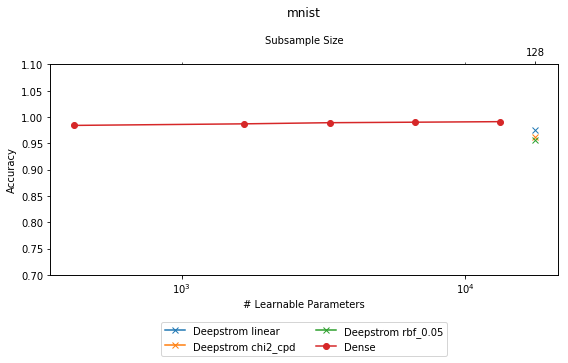

In [43]:
lst_df_kernel = []
kernel_names = set(df_deepstrom_grid["kernel"].values)
nys_size = set(df_deepstrom_grid["--nys-size"].values)

for k_name in kernel_names:
    df_k = df_deepstrom_grid[df_deepstrom_grid["kernel"] == k_name]
    df_k_sorted = get_sorted_acc_for_dataset(df_k, "mnist")
    lst_df_kernel.append(df_k_sorted.iloc[0:1])

df_deepstrom_grid_processed = pd.concat(lst_df_kernel)
                         
create_figure_from_df_deepstrom(df_deepstrom_grid_processed, df_dense, "grid_search")

2019-01-14 10:20:12,207 [2287] DEBUG    root: Nystrom possible sizes are: {32, 64, 128, 8, 16}
2019-01-14 10:20:12,208 [2287] DEBUG    root: Kernel functions are: {'linear', 'chi2_cpd', 'rbf'}


--batch-size  --dropout --gamma  --learning-rate --nb-stack  --nys-size --out-dim  --real-fastfood  --seed  --tanh-activation       ...       deepfriedconvnet    kernel    network  test_acc  test_eval_time   train_time  training_time   val_acc  val_eval_time  file_timestamp
0            128        1.0     1.0           0.0001       None          16      None            False       0              False       ...                  False       rbf  deepstrom  0.932692        0.252535  2024.045805           None  0.923778       0.322065      1546908020
1            128        1.0    None           0.0001       None           8      None            False       0              False       ...                  False    linear  deepstrom  0.933093        0.259802  2201.852409           None  0.925781       0.339634      1546879316
2            128        1.0     1.0           0.0001       None         128      None            False       0              False       ...                  False       rbf  deepstrom  0.965645        0.240070  1816.051002           None  0.965645       0.336579      1546911974
6            128        1.0     1.0           0.0001       None          32      None            False       0              False       ...                  False       rbf  deepstrom  0.961238        0.261577  2010.837394           None  0.956230       0.328674      1546910060
7            128        1.0    None           0.0001       None          32      None            False       0              False       ...                  False    linear  deepstrom  0.960637        0.259691  2219.141911           None  0.956230       0.354580      1546884007
11           128        1.0     0.1           0.0001       None         128      None            False       0              False       ...                  False       rbf  deepstrom  0.974559        0.241471  1981.380245           None  0.974058       0.335224      1546911754
12           128        1.0    None           0.0001       None          64      None            False       0              False       ...                  False  chi2_cpd  deepstrom  0.946014        0.344865  2279.829829           None  0.941707       0.434396      1546886237
13           128        1.0    None           0.0001       None          16      None            False       0              False       ...                  False    linear  deepstrom  0.955929        0.461002  3989.239658           None  0.946214       0.616996      1546882824
17           128        1.0    None           0.0001       None         128      None            False       0              False       ...                  False    linear  deepstrom  0.967248        0.466803  3918.996891           None  0.963141       0.607650      1546886839
19           128        1.0    0.01           0.0001       None           8      None            False       0              False       ...                  False       rbf  deepstrom  0.896835        0.260317  2402.729009           None  0.880509       0.365236      1546903318
22           128        1.0    None           0.0001       None          16      None            False       0              False       ...                  False  chi2_cpd  deepstrom  0.959335        0.254009  2242.645634           None  0.951322       0.364692      1546883789
25           128        1.0     1.0           0.0001       None          64      None            False       0              False       ...                  False       rbf  deepstrom  0.962640        0.258569  1906.477137           None  0.959034       0.354456      1546910639
26           128        1.0    0.01           0.0001       None          64      None            False       0              False       ...                  False       rbf  deepstrom  0.738181        0.252228  2217.483448           None  0.740184       0.362291      1546910231
27           128        1.0     0.1           0.0001       None          32      None            F

[0.93309295 0.95592949 0.96063702 0.96895032 0.9672476 ]
[0.92568109 0.95933494 0.95783253 0.94601362 0.96654647]
[0.94691506 0.93269231 0.96123798 0.96264022 0.96564503]
[0.91977163 0.95873397 0.96444311 0.96033654 0.97455929]
[0.89683494 0.94491186 0.95763221 0.73818109 0.84014423]


array([  416,  1664,  3328,  6656, 13312])

array([0.98409455, 0.98707933, 0.98924279, 0.99020433, 0.99122596])

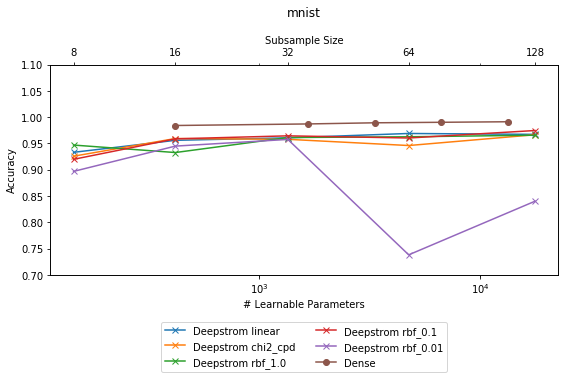

In [44]:
# lst_df_kernel = []
# kernel_names = set(df_deepstrom_grid["kernel"].values)
# nys_size = set(df_deepstrom_grid["--nys-size"].values)

# for k_name in kernel_names:
#     df_k = df_deepstrom_grid[df_deepstrom_grid["kernel"] == k_name]
#     df_k_sorted = get_sorted_acc_for_dataset(df_k, "mnist")
#     lst_df_kernel.append(df_k_sorted.iloc[0:1])

# df_deepstrom_grid_processed = pd.concat(lst_df_kernel)
                         
create_figure_from_df_deepstrom(df_deepstrom, df_dense, "normal")